This requires the IEX_TOKEN environment variable to be set to the IEX API token.

In [1]:
from iexfinance.stocks import Stock, get_historical_data
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
df_spx = pd.read_csv('sp500_constituents.csv',encoding = "ISO-8859-1",quotechar='"')

In [3]:
df_pricechanges = pd.DataFrame(index=df_spx["Symbol"], 
                               columns=["Symbol", "Security", "GICS_Sector", "GICS_Sub_Industry", 
                                        "latestPrice", "lastweekPrice", "week52High", 
                                        "pct_change1D", "pct_change1W", "pct_changeFrom1YHigh"])


In [4]:
def retrieve_new_data():
    lastweek_date = datetime.today() - timedelta(days=7) - timedelta(days=max(datetime.today().weekday() - 4, 0))
    
    print("Today:",datetime.today(),", Last week:",lastweek_date)

    for i in range(len(df_spx)):
        print("Retrieving " + df_spx["Symbol"][i] + "    ", end="\r", flush=True)
        df_pricechanges["Symbol"][i] = df_spx["Symbol"][i]
        df_pricechanges["Security"][i] = df_spx["Security"][i]
        df_pricechanges["GICS_Sector"][i] = df_spx["GICS_Sector"][i]
        df_pricechanges["GICS_Sub_Industry"][i] = df_spx["GICS_Sub_Industry"][i]

        quote = Stock(df_spx["Symbol"][i], output_format="json").get_quote()
        df_pricechanges["latestPrice"][i] = quote["latestPrice"]
        df_pricechanges["week52High"][i] = quote["week52High"]
        df_pricechanges["pct_change1D"][i] = quote["changePercent"]
        df_pricechanges["pct_changeFrom1YHigh"][i] = (quote["latestPrice"] / quote["week52High"] - 1) if quote["week52High"] is not None else None 

        historical_data = get_historical_data(df_spx["Symbol"][i], start=lastweek_date.strftime("%Y%m%d"), close_only=True)
        df_pricechanges["lastweekPrice"][i] = historical_data[lastweek_date.strftime("%Y-%m-%d")]["close"] if historical_data[lastweek_date.strftime("%Y-%m-%d")] is not None else None
        df_pricechanges["pct_change1W"][i] = quote["latestPrice"]/ df_pricechanges["lastweekPrice"][i]  - 1 if df_pricechanges["lastweekPrice"][i] is not None else None 

In [5]:
def make_charts(data, value, title):
    data_subset = data[data.GICS_Sector.isin(["Communication Services", 
                                                               "Information Technology", 
                                                               "Consumer Staples", "Financials"])]
    if value == "pct_changeFrom1YHigh":
        hlines = [-0.25,-0.4, -0.5]
    else:
        hlines = [-0.05,-0.1]
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.title(title + " drop")
    plt.scatter('Symbol', value, c=data.head(10).GICS_Sector.cat.codes, s=300, cmap='Set1', data=data.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')

    plt.subplot(1,2,2)
    plt.title(title + " drop in tech, consumer staples, financials")
    plt.scatter('Symbol', value, c=data_subset.head(10).GICS_Sector.cat.codes, cmap='Set1', s=300, data=data_subset.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')
    plt.show()

Choose whether to read an existing file or run the latest data from IEX

In [6]:
### Run latest data from IEX
retrieve_new_data()
df_pricechanges.head()
df_pricechanges.to_csv("results/pricechanges_" + datetime.today().strftime("%Y-%m-%d") + ".csv")
df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

Today: 2020-08-05 10:22:40.297759 , Last week: 2020-07-29 10:22:40.297759


In [7]:
### Read existing file
#df_pricechanges = pd.read_csv('results/pricechanges_2020-02-07.csv',encoding = "ISO-8859-1",quotechar='"')
#df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

Largest drops in the day

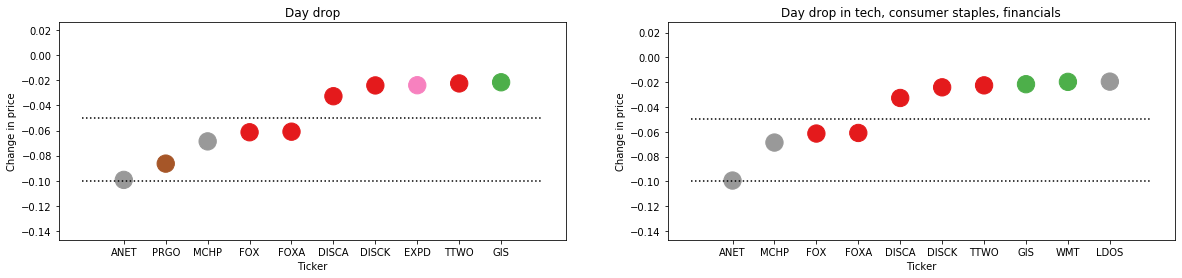

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,pct_change1D
Symbol,,,,,,
ANET,ANET,Arista Networks,Information Technology,Communications Equipment,237.77,-0.09932
PRGO,PRGO,Perrigo,Health Care,Pharmaceuticals,50.36,-0.08636
MCHP,MCHP,Microchip Technology,Information Technology,Semiconductors,99.95,-0.06867
FOX,FOX,Fox Corporation (Class B),Communication Services,Movies & Entertainment,25.07,-0.0614
FOXA,FOXA,Fox Corporation (Class A),Communication Services,Movies & Entertainment,25.045,-0.06093
DISCA,DISCA,"Discovery, Inc. (Class A)",Communication Services,Broadcasting,21.29,-0.03271
DISCK,DISCK,"Discovery, Inc. (Class C)",Communication Services,Broadcasting,19.215,-0.02412
EXPD,EXPD,Expeditors,Industrials,Air Freight & Logistics,84.76,-0.02395
TTWO,TTWO,Take-Two Interactive,Communication Services,Interactive Home Entertainment,173.52,-0.02253


In [8]:
day_drop = df_pricechanges.sort_values(by=['pct_change1D'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice", "pct_change1D"]]
make_charts(day_drop, "pct_change1D", "Day")
day_drop.head(20)

Largest drops from 1 week

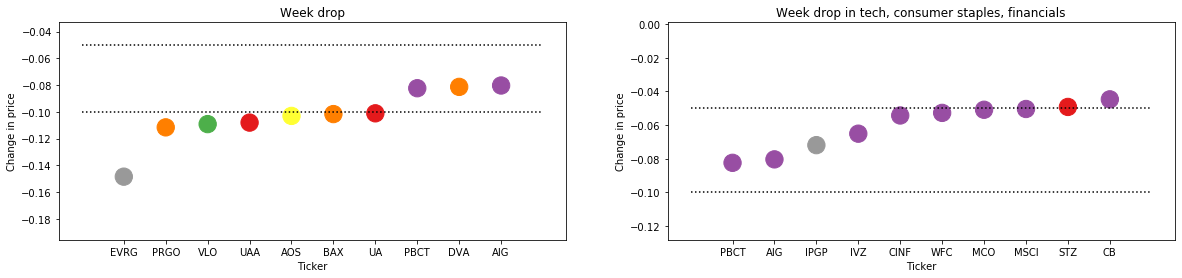

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,lastweekPrice,pct_change1W
Symbol,,,,,,,
EVRG,EVRG,Evergy,Utilities,Electric Utilities,54.775,64.33,-0.148531
PRGO,PRGO,Perrigo,Health Care,Pharmaceuticals,50.36,56.69,-0.11166
VLO,VLO,Valero Energy,Energy,Oil & Gas Refining & Marketing,53.17,59.69,-0.109231
UAA,UAA,Under Armour (Class A),Consumer Discretionary,"Apparel, Accessories & Luxury Goods",10.355,11.61,-0.108096
AOS,AOS,A.O. Smith Corp,Industrials,Building Products,47.805,53.3,-0.103096
BAX,BAX,Baxter International Inc.,Health Care,Health Care Equipment,81.5,90.73,-0.10173
UA,UA,Under Armour (Class C),Consumer Discretionary,"Apparel, Accessories & Luxury Goods",9.285,10.33,-0.101162
PBCT,PBCT,People's United Financial,Financials,Thrifts & Mortgage Finance,10.525,11.47,-0.0823888
DVA,DVA,DaVita Inc.,Health Care,Health Care Facilities,83.87,91.3,-0.0813801


In [9]:
week_drop = df_pricechanges.sort_values(by=['pct_change1W'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice","lastweekPrice", "pct_change1W"]]
make_charts(week_drop, "pct_change1W", "Week")
week_drop.head(20)

Largest drops from 1 year high

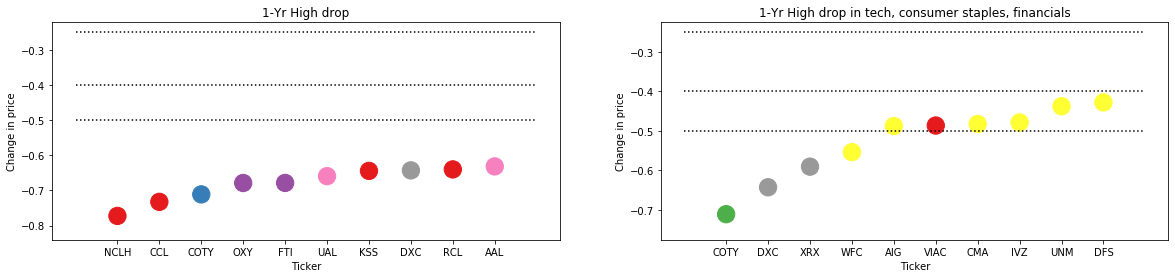

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,week52High,pct_changeFrom1YHigh
Symbol,,,,,,,
NCLH,NCLH,Norwegian Cruise Line Holdings,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",13.6,59.78,-0.772499
CCL,CCL,Carnival Corp.,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",13.895,51.94,-0.73248
COTY,COTY,"Coty, Inc",Consumer Staples,Personal Products,3.875,13.42,-0.711252
OXY,OXY,Occidental Petroleum,Energy,Oil & Gas Exploration & Production,16.205,50.46,-0.678855
FTI,FTI,TechnipFMC,Energy,Oil & Gas Equipment & Services,8.525,26.53,-0.678666
UAL,UAL,United Airlines Holdings,Industrials,Airlines,32.41,95.16,-0.659416
KSS,KSS,Kohl's Corp.,Consumer Discretionary,General Merchandise Stores,21.08,59.28,-0.644399
DXC,DXC,DXC Technology,Information Technology,IT Consulting & Other Services,18.59,52.07,-0.642981
RCL,RCL,Royal Caribbean Cruises Ltd,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",48.69,135.32,-0.640186


In [10]:
yearhigh_drop = df_pricechanges.sort_values(by=['pct_changeFrom1YHigh'])[["Symbol", "Security", "GICS_Sector", 
                                            "GICS_Sub_Industry", "latestPrice", "week52High","pct_changeFrom1YHigh"]]
make_charts(yearhigh_drop, "pct_changeFrom1YHigh", "1-Yr High")
yearhigh_drop.head(40)